# Milopy

Aims:
- DA testing to look for disease (T21) or health-specific cell populations
- Disease hearts are only at PCW13 and 14, whereas atlas is 4-20, so need to be careful we are not finding age-related changes rather than disease related --> use age-matched healthy data is one option (will start with this)
- Other issue is sampling bias: to avoind this we will only compare samples where there was the same type of sampling in disease and healthy ('whole sample', 'LV', 'RV')

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scanpy as sc
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import milopy
import milopy.core as milo

## Session info

In [51]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',dpi_save=300)

In [2]:
import session_info
session_info.show()

## Load dataset

In [3]:
adata = sc.read("/lustre/scratch126/cellgen/team205/jc48/jupyter/scArches/results/AtlasT21_WithContCovariates_MidGrainModified_AllCompartments/anndata/AtlasT21_WithContCovariates_MidGrainModified_AllCompartments_integrated_object_with_Celltypist.h5ad")
adata

AnnData object with n_obs × n_vars = 373831 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'MidGrainModified', 'leiden', 'original_or_new', 'batch', 'cell_type', 'scANVI_predictions', 'fine_CellTypist_predicted_labels', '

In [4]:
adata.X.data

array([1., 1., 5., ..., 2., 1., 1.], dtype=float32)

In [5]:
adata.obs.combinedID.value_counts()

na                                       86328
BHF_F_Hea13188319_BHF_F_Hea13187621      18906
BHF_F_Hea13188321_BHF_F_Hea13187623      14724
BHF_F_Hea13168898_BHF_F_Hea13168514      13785
BHF_F_Hea13168899_BHF_F_Hea13168515      12280
7089STDY13216920_BHF_F_Hea13242527       11410
BHF_F_Hea13168896_BHF_F_Hea13168512      11131
BHF_F_Hea11933666_BHF_F_Hea11596619       9987
BHF_F_Hea13168894_BHF_F_Hea13168510       9955
BHF_F_Hea11933667_BHF_F_Hea11596620       9951
7089STDY13216921_BHF_F_Hea13242528        9791
BHF_F_Hea13168895_BHF_F_Hea13168511       9401
BHF_F_Hea13168897_BHF_F_Hea13168513       9262
BHF_F_Hea11933669_BHF_F_Hea11596622       9150
BHF_F_Hea11933668_BHF_F_Hea11596621       9146
BHF_F_Hea13188325_BHF_F_Hea13187627       8892
BHF_F_Hea13188323_BHF_F_Hea13187625       7784
BHF_F_Hea13188327_BHF_F_Hea13187629       7581
BHF_F_Hea13168893_BHF_F_Hea13168509       6720
BHF_F_Hea13188322_BHF_F_Hea13187624       6471
BHF_F_Hea13188318_BHF_F_Hea13187620       6427
BHF_F_Hea1318

In [6]:
counts = adata.obs['combinedID'].value_counts()
low_cell_number_batches = counts[counts < 100].index.tolist()
print(low_cell_number_batches)

['7089STDY13216923_BHF_F_Hea13242530']


In [7]:
print(adata.shape)
adata=adata[~adata.obs.combinedID.isin(low_cell_number_batches)]
print(adata.shape)

(373831, 36601)
(373830, 36601)


In [8]:
adata.obs.donor.value_counts()

Hst41      104878
Hst42       54262
Hst33       38234
Hst39       25386
Hst44       22096
C99         17547
C92         13770
C94         12985
Hst40        9707
C97          9702
BRC2251      9121
BRC2256      7948
Hst36        7268
BRC2253      6854
C86          6376
BRC2260      6004
BRC2263      5662
BRC2262      4129
C87          3907
C98          2660
C104         2490
C85          2436
C82           408
Name: donor, dtype: int64

In [9]:
adata.obs['fine_grain'] = adata.obs['fine_grain'].astype('str')
adata.obs['fine_CellTypist_majority_voting'] = adata.obs['fine_CellTypist_majority_voting'].astype('str')
adata.obs['fine_grain_merged'] = adata.obs['fine_grain'].replace('nan', np.nan).fillna(adata.obs['fine_CellTypist_majority_voting'].replace('nan', np.nan))
adata.obs['fine_grain_merged'] = adata.obs['fine_grain_merged'].astype('category')

In [10]:
adata.obs['mid_grain'] = adata.obs['mid_grain'].astype('str')
adata.obs['mid_CellTypist_majority_voting'] = adata.obs['mid_CellTypist_majority_voting'].astype('str')
adata.obs['mid_grain_merged'] = adata.obs['mid_grain'].replace('nan', np.nan).fillna(adata.obs['mid_CellTypist_majority_voting'].replace('nan', np.nan))
adata.obs['mid_grain_merged'] = adata.obs['mid_grain_merged'].astype('category')

In [11]:
adata.obs['diagnosis'] = adata.obs['original_or_new'].map({'original': 'Atlas', 'new': 'T21'})
adata.obs.diagnosis.value_counts()

Atlas    297472
T21       76358
Name: diagnosis, dtype: int64

In [12]:
pd.crosstab(adata.obs.diagnosis, adata.obs.fine_grain_merged)

fine_grain_merged  AtrialCardiomyocytesCycling  AtrialCardiomyocytesLeft  \
diagnosis                                                                  
T21                                        807                      7394   
Atlas                                     2396                      6606   

fine_grain_merged  AtrialCardiomyocytesRight  \
diagnosis                                      
T21                                     1485   
Atlas                                  10696   

fine_grain_merged  AtrioventricularNodeCardiomyocytes  BCells  BCellsMS4A1pos  \
diagnosis                                                                       
T21                                               309       0               0   
Atlas                                             937    2058            3470   

fine_grain_merged  ChromaffinCells  CoronaryArterialEndothelialCells  \
diagnosis                                                              
T21                              0                               219   
Atlas                          228                               846   

fine_grain_merged  CoronaryCapillaryEndothelialCells  CoronaryPericytes  ...  \
diagnosis                                                                ...   
T21                                             1629                474  ...   
Atlas                                           6392               2131  ...   

fine_grain_merged  TregsCD4pos  ValveEndothelialCells  ValveInterstitialCells  \
diagnosis                                                                       
T21                          0                      0                    1164   
Atlas                     2096                   1296                    7398   

fine_grain_merged  VentricularCardiomyocytesCycling  \
diagnosis                                             
T21                                            1669   
Atlas                                          8195   

fine_grain_merged  VentricularCardiomyocytesLeftCompact  \
diagnosis                                                 
T21                                                4888   
Atlas                                             15590   

fine_grain_merged  VentricularCardiomyocytesLeftTrabeculated  \
diagnosis                                                      
T21                                                     1986   
Atlas                                                   6997   

fine_grain_merged  VentricularCardiomyocytesRightCompact  \
diagnosis                                                  
T21                                                 2734   
Atlas                                              16215   

fine_grain_merged  VentricularCardiomyocytesRightTrabeculated  \
diagnosis                                                       
T21                                                      1676   
Atlas                                                    3101   

fine_grain_merged  VentricularConductionSystemDistal  \
diagnosis                                              
T21                                              166   
Atlas                                            960   

fine_grain_merged  VentricularConductionSystemProximal  
diagnosis                                               
T21                                                246  
Atlas                                             2209  

[2 rows x 63 columns]

In [13]:
pd.crosstab(adata.obs.region,adata.obs.diagnosis)

diagnosis                          T21   Atlas
region                                        
aorta                                0   28120
apex                                 0   13942
atria                                0    4118
atrial septum                        0    4781
base                                 0   26762
ductus arteriosus                    0   20393
great vessels                     6377       0
heart without node                   0    9656
left atria                       14724       0
left ventricle                    6471    5829
node                                 0    9671
outflow tract                        0    1504
pericardium                      18906   19356
pulmonary arches and branches        0   26065
right ventricle                   7784    5555
right ventricle and papillaries      0    6427
whole sample                     22096  115293

In [14]:
list_of_regions=['whole sample','left ventricle','right ventricle'] # consider adding pericardium if interested

print(adata.shape)
adata=adata[adata.obs.region.isin(list_of_regions)]
print(adata.shape)

(373830, 36601)
(163028, 36601)


In [15]:
list_of_cell_types=[
    'VentricularCardiomyocytesLeftCompact',
    'VentricularCardiomyocytesLeftTrabeculated',
    'VentricularCardiomyocytesRightCompact',
    'VentricularCardiomyocytesRightTrabeculated',
]

print(adata.shape)
adata=adata[adata.obs.fine_grain_merged.isin(list_of_cell_types)]
print(adata.shape)

(163028, 36601)
(41894, 36601)


In [16]:
print(adata.shape)
adata=adata[adata.obs.cell_or_nuclei=='nuclei']
print(adata.shape)

(41894, 36601)
(38279, 36601)


In [17]:
pd.crosstab(adata.obs.diagnosis, adata.obs.fine_grain_merged)

fine_grain_merged  VentricularCardiomyocytesLeftCompact  \
diagnosis                                                 
T21                                                4885   
Atlas                                             10806   

fine_grain_merged  VentricularCardiomyocytesLeftTrabeculated  \
diagnosis                                                      
T21                                                     1982   
Atlas                                                   4818   

fine_grain_merged  VentricularCardiomyocytesRightCompact  \
diagnosis                                                  
T21                                                 2727   
Atlas                                               9608   

fine_grain_merged  VentricularCardiomyocytesRightTrabeculated  
diagnosis                                                      
T21                                                      1676  
Atlas                                                    1777

Notes
- 13 batches (libraries)
- 2 conditions: T21, atlas
- The `fine_grain_merged` corresponds to the cell types.

## Choose method of KNN graph construction (which latent space to use)

To perform DA analysis with Milo, we need to construct a KNN graph that is representative of the true biological similarities between cells, as we do when performing clustering or UMAP visualization of a single-cell dataset. This means (A) building a common low-dimensional space for all samples and (B) minimizing cell-cell similarities driven by technical factors (i.e. batch effects).

In [18]:
sc.pp.neighbors(adata, use_rep='X_scArches')

In [19]:
sc.tl.umap(adata,min_dist=0.1)

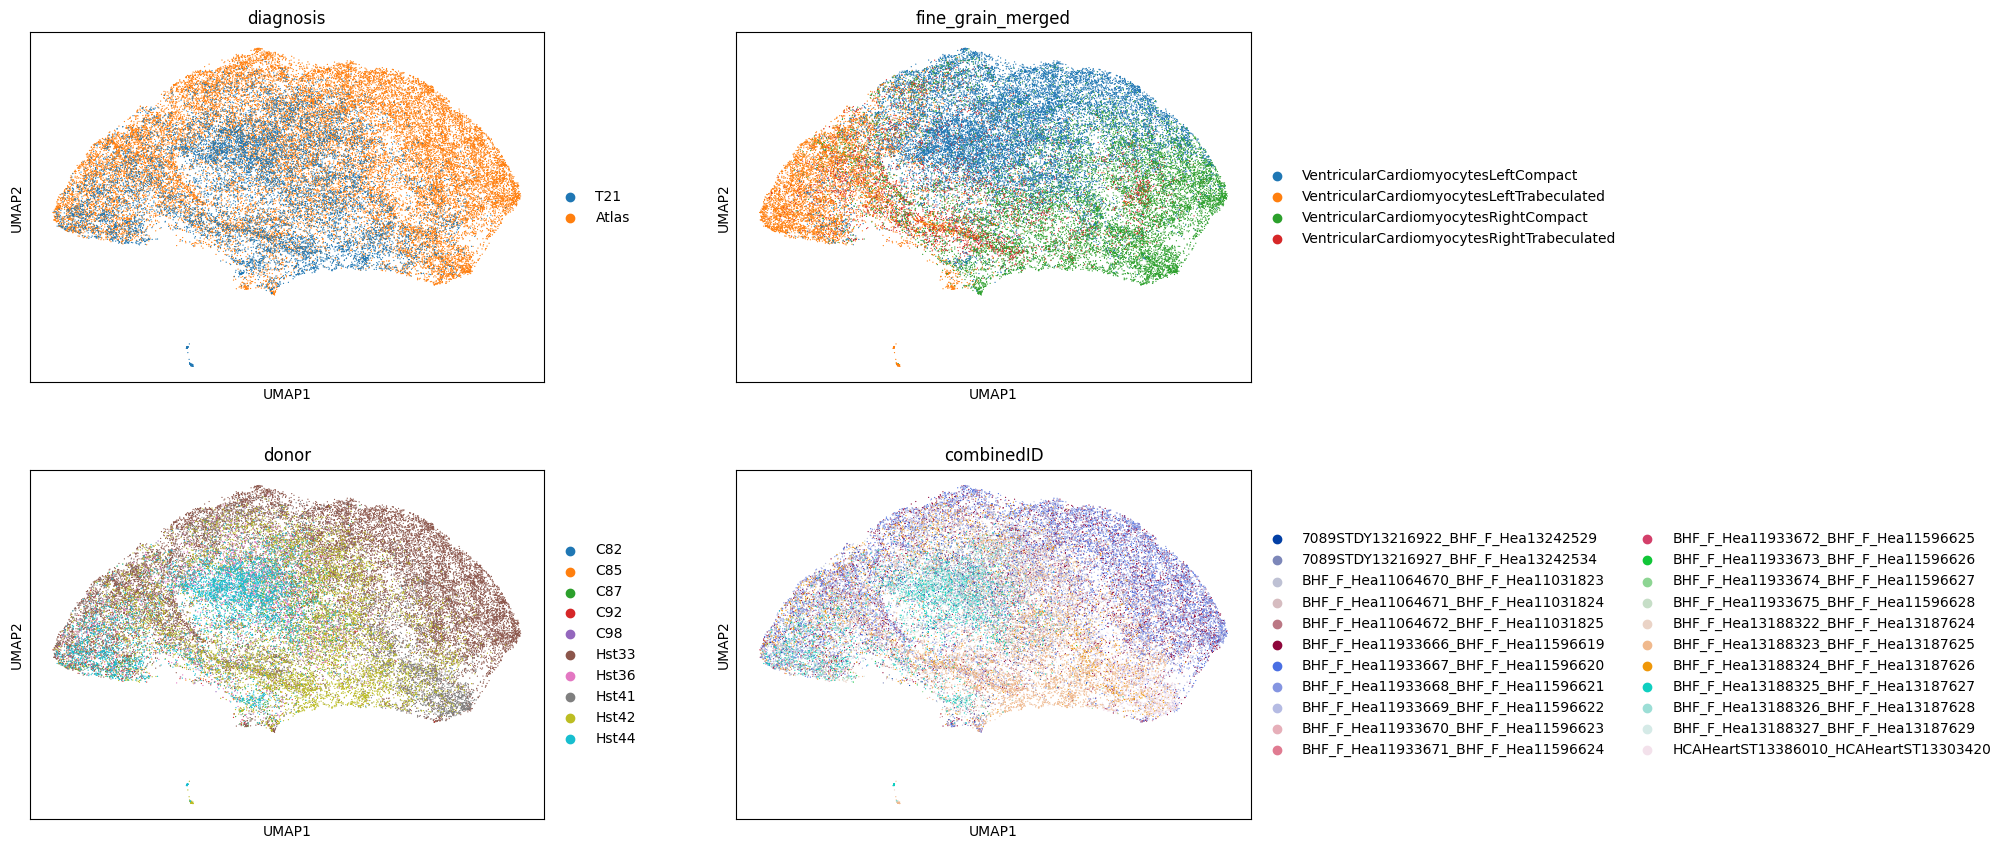

In [20]:
sc.pl.umap(adata, color=['diagnosis', 'fine_grain_merged', 'donor','combinedID'], ncols=2, wspace=0.25)

While cell type clusters are broadly captured, we can see residual separation between batches, also for replicates of the same treatment. If we define neighbourhoods on this KNN graph we might have a large fraction of neighbourhoods containing cells from just one or a few batches. This could introduce false negatives, if the variance in number of cells between replicates is too low (e.g. 0 cells for all replicates) or too high (e.g. all zero cells except for one replicate with a large number of cells), but also false positives, especially when, like in this case, the number of replicates per condition is low. 

To minimize these errors, we apply the scVI method to learn a batch-corrected latent space. 

In [169]:
# prepare adata for scVI (counts layer)
print(adata.X.data[:5])
adata.layers["counts"]=adata.X.copy()
adata.layers["logcounts"]=sc.pp.log1p(adata.layers['counts']).copy()
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
print(adata.X.data[:5])

[2. 1. 1. 2. 1.]
[0.41374126 0.22811745 0.22811745 0.41374126 0.22811745]


In [ ]:
# Run scVI to generate better embedding (specific to this data subset)

import scvi

# make a HVG-subsetted object for scVI
adata_scvi = adata[:, adata.var['highly_variable']].copy()

# setup anndata for scVI
scvi.model.SCVI.setup_anndata(
    adata_scvi,
    layer="counts",
    batch_key='combinedID',
    continuous_covariate_keys=['total_counts','pct_counts_mt','pct_counts_ribo'] # consider 'S_score','G2M_score'
)

# Creating and training a model
vae=scvi.model.SCVI(
    adata_scvi,
    n_hidden = 128,
    n_latent = 50,
    n_layers = 1,
    dispersion = 'gene-batch'
)

vae.view_anndata_setup(adata_scvi)

# Train model
vae.train(max_epochs=100)

# Convergence plot
x = np.linspace(1, (len(vae.history['elbo_train'])), (len(vae.history['elbo_train'])))
plt.plot(x, vae.history['elbo_train'], label="train")
plt.title('Convergence')
plt.xlabel('epoch')
plt.ylabel('elbo_train')
plt.show()
plt.clf()

Anndata setup with scvi-tools version 1.0.0.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'combinedID',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  22   │
│         n_cells          │ 38279 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   3   │
│         n_labels         │   1   │
│          n_vars          │ 3447  │
└──────────────────────────┴───────┘

                            Data Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Registry Key      ┃            scvi-tools Location            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X           │          adata.layers['counts']           │
│         batch         │         adata.obs['_scvi_batch']          │
│ extra_continuous_covs │ adata.obsm['_scvi_extra_continuous_covs'] │
│        labels         │         adata.obs['_scvi_labels']         │
└───────────────────────┴───────────────────────────────────────────┘

                                  batch State Registry                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃              Categories               ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['combinedID'] │  7089STDY13216922_BHF_F_Hea13242529   │          0          │
│                         │  7089STDY13216927_BHF_F_Hea13242534   │          1          │
│                         │  BHF_F_Hea11064670_BHF_F_Hea11031823  │          2          │
│                         │  BHF_F_Hea11064671_BHF_F_Hea11031824  │          3          │
│                         │  BHF_F_Hea11064672_BHF_F_Hea11031825  │          4          │
│                         │  BHF_F_Hea11933666_BHF_F_Hea11596619  │          5          │
│                         │  BHF_F_Hea11933667_BHF_F_Hea11596620  │          6          │
│                         │  BHF_F_Hea11933668_BHF_F_Hea11596621  │          7          │
│                         │  BHF_F_Hea11933669_BHF_F_Hea11596622  │          8          │
│                         │  BHF_F_Hea11933670_BHF_F_Hea11596623  │          9          │
│                         │  BHF_F_Hea11933671_BHF_F_Hea11596624  │         10          │
│                         │  BHF_F_Hea11933672_BHF_F_Hea11596625  │         11          │
│                         │  BHF_F_Hea11933673_BHF_F_Hea11596626  │         12          │
│                         │  BHF_F_Hea11933674_BHF_F_Hea11596627  │         13          │
│                         │  BHF_F_Hea11933675_BHF_F_Hea11596628  │         14          │
│                         │  BHF_F_Hea13188322_BHF_F_Hea13187624  │         15          │
│                         │  BHF_F_Hea13188323_BHF_F_Hea13187625  │         16          │
│                         │  BHF_F_Hea13188324_BHF_F_Hea13187626  │         17          │
│                         │  BHF_F_Hea13188325_BHF_F_Hea13187627  │         18          │
│                         │  BHF_F_Hea13188326_BHF_F_Hea13187628  │         19          │
│                         │  BHF_F_Hea13188327_BHF_F_Hea13187629  │         20          │
│                         │ HCAHeartST13386010_HCAHeartST13303420 │         21          │
└─────────────────────────┴───────────────────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
└──────────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|                                                                                                                                                                                                    | 0/100 [00:00<?, ?it/s]

In [ ]:
# add the latent space to adata
adata.obsm['X_scVI'] = vae.get_latent_representation()

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI")

In [ ]:
sc.tl.umap(adata, min_dist=0.1)

In [ ]:
sc.pl.umap(adata, color=['diagnosis', 'fine_grain_merged', 'donor','combinedID'], ncols=2, wspace=0.25)

## Define neighbourhoods

Milo is a KNN-based model to test for differential abundance and therefore operates on neighborhoods of cells. Hence, we first we need to create these neighborhoods. Here a neighbourhood is defined as all the group of cells connected by an edge to the same cell (_index cell_) in an undirected KNN graph. While we could in principle construct one neighbourhood for each cell in the graph, this would be inefficient and significantly increase the multiple testing burden. Therefore Milo samples a refined set of cells to select as index cells for neighbourhoods, starting from a random sample of a fraction of cells. The initial proportion can be specified using the `prop` argument in the `milo.make_nhoods` function. As by default, we recommend using `prop=0.1` (10% of cells) and to reduce to 5% or 2% to increase scalability on large datasets (> 100k cells).

By default, Milo uses the neighbours from `.obsp`. Therefore, ensure that `sc.pp.neighbors` was run on the correct represenation, i.e. an integrated latent space if batch correction was required. 

Now the binary assignment of cells to neighbourhood is stored in `adata.obsm['nhoods']`. Here we can see that, as expected, the number of neighbourhoods should be less or equal to the number of cells in the graph times the `prop` parameter. In this case, less than 984 neighbourhoods. 
Of note, The number of neighbourhoods is smaller than 10% of the cells because the sampling algorithm starts from a sample of 10% of the cells but can then converge to the same cells during refinement 

At this point we need to check the mean number of cells in each neighbourhood, to make sure the neighbourhoods contain enough cells to detect differences between samples

Here we expect the **minimum** number of cells to be equal to the k parameter used during graph construction (k=10 in this case).

We can use the following rule of thumb: if we have cells from $s$ samples, we can expect that to have a **median** of $m$ cells from each sample in a neighbourhood, the total number of cells $n$ should be $n \geq m \times s$. In this case we have data from 4 samples, if we want to have on average 3 cells from each sample in a neighbourhood, the minimum number of cells should be 12. 

In practice, here we have a large number of neighbourhoods with fewer than 12 cells, which could lead to an underpowered test. To solve this, we just need to recompute the KNN graph using `n_neighbors=12`. To distinguish this KNN graph used for neighbourhood-level DA analysis from the graph used for UMAP building, we will store this as a distinct graph in `adata.obsp`.

In [21]:
latent_space='X_scArches'

In [22]:
sample_col='combinedID'

In [23]:
n_samples=len(adata.obs[sample_col].unique())
n_samples

22

In [24]:
n_neighbors=n_samples*3
n_neighbors

66

In [25]:
%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep=latent_space, key_added='milo')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.29 µs


In [26]:
# fixes subsequent error which can occur when calling make_nhoods()
adata.obsm[adata.uns['neighbors']['params']['use_rep']] = adata.obsm[adata.uns['neighbors']['params']['use_rep']].values.copy()

In [27]:
%time
milo.make_nhoods(adata, neighbors_key='milo', prop=0.05)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


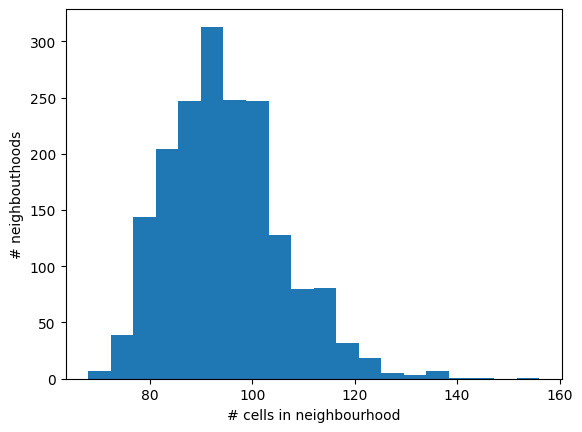

In [28]:
nhood_size = adata.obsm['nhoods'].toarray().sum(0)
plt.hist(nhood_size, bins=20);
plt.xlabel('# cells in neighbourhood');
plt.ylabel('# neighbouthoods');

In [29]:
np.median(nhood_size)

94.0

## Count cells in neighbourhoods

In the next step, Milo counts cells belonging to each of the samples.

In [30]:
milo.count_nhoods(adata, sample_col=sample_col)

This stores a neighbourhood-level AnnData object, where `nhood_adata.X` stores the number of cells from each sample in each neighbourhood

In [31]:
adata.uns['nhood_adata']

AnnData object with n_obs × n_vars = 1806 × 22
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

We can verify that the average number of cells per sample times the number of samples roughly corresponds to the number of cells in a neighbourhood.

Text(0, 0.5, 'Mean # cells per sample in nhood')

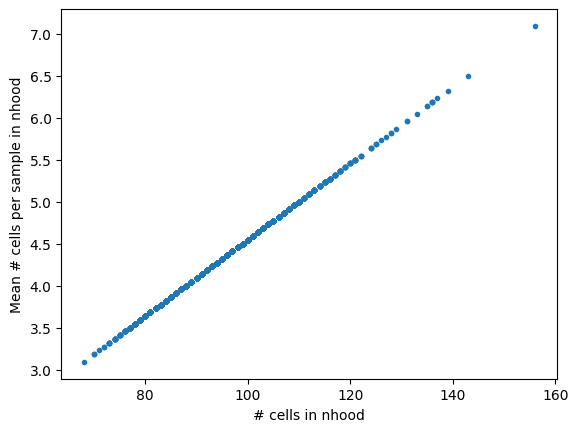

In [32]:
mean_n_cells = adata.uns['nhood_adata'].X.toarray().mean(1)
plt.plot(nhood_size, mean_n_cells, '.');
plt.xlabel('# cells in nhood');
plt.ylabel('Mean # cells per sample in nhood')

## Run differential abundance test on neighbourhoods

Milo uses edgeR's QLF test to test if there are statistically significant differences between the number of cells from a condition of interest in each neighborhood. 

### Test on categorical covariates

Here we are interested in detecting in which neighbourhoods there is a significant increase or decrease of cells in response to T21 status. Since the `condition` covariate stores many different types of infection, we need to specify which conditions we need to contrast in our differential abundance test (following a convention used in R, by default the last level of the covariate against the rest will be used). To specify the comparison, we use the syntax used for GLMs in R (https://genomicsclass.github.io/book/pages/expressing_design_formula.html).

In [33]:
# add age as a continous variable
import re

def age_to_days(age_str):
    match = re.match(r'(\d+)W(\d+)D', age_str)
    if match:
        weeks, days = map(int, match.groups())
        return float(weeks * 7 + days)
    else:
        return None

# Assuming 'adata' is an AnnData object
adata.obs['age_days'] = adata.obs['age'].apply(age_to_days)
adata.obs['age_days']=adata.obs['age_days'].astype(float)

In [34]:
design_df = adata.obs[[sample_col,"diagnosis","age_days"]]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df[sample_col]
design_df.sort_values('age_days')

combinedID  \
combinedID                                                                     
BHF_F_Hea11933673_BHF_F_Hea11596626      BHF_F_Hea11933673_BHF_F_Hea11596626   
BHF_F_Hea11933672_BHF_F_Hea11596625      BHF_F_Hea11933672_BHF_F_Hea11596625   
BHF_F_Hea11933671_BHF_F_Hea11596624      BHF_F_Hea11933671_BHF_F_Hea11596624   
BHF_F_Hea11933670_BHF_F_Hea11596623      BHF_F_Hea11933670_BHF_F_Hea11596623   
BHF_F_Hea11933675_BHF_F_Hea11596628      BHF_F_Hea11933675_BHF_F_Hea11596628   
BHF_F_Hea11933674_BHF_F_Hea11596627      BHF_F_Hea11933674_BHF_F_Hea11596627   
BHF_F_Hea11064672_BHF_F_Hea11031825      BHF_F_Hea11064672_BHF_F_Hea11031825   
BHF_F_Hea11064671_BHF_F_Hea11031824      BHF_F_Hea11064671_BHF_F_Hea11031824   
BHF_F_Hea11064670_BHF_F_Hea11031823      BHF_F_Hea11064670_BHF_F_Hea11031823   
7089STDY13216922_BHF_F_Hea13242529        7089STDY13216922_BHF_F_Hea13242529   
7089STDY13216927_BHF_F_Hea13242534        7089STDY13216927_BHF_F_Hea13242534   
BHF_F_Hea11933668_BHF_F_Hea11596621      BHF_F_Hea11933668_BHF_F_Hea11596621   
BHF_F_Hea13188326_BHF_F_Hea13187628      BHF_F_Hea13188326_BHF_F_Hea13187628   
BHF_F_Hea11933667_BHF_F_Hea11596620      BHF_F_Hea11933667_BHF_F_Hea11596620   
BHF_F_Hea11933666_BHF_F_Hea11596619      BHF_F_Hea11933666_BHF_F_Hea11596619   
BHF_F_Hea13188325_BHF_F_Hea13187627      BHF_F_Hea13188325_BHF_F_Hea13187627   
BHF_F_Hea11933669_BHF_F_Hea11596622      BHF_F_Hea11933669_BHF_F_Hea11596622   
BHF_F_Hea13188327_BHF_F_Hea13187629      BHF_F_Hea13188327_BHF_F_Hea13187629   
BHF_F_Hea13188322_BHF_F_Hea13187624      BHF_F_Hea13188322_BHF_F_Hea13187624   
BHF_F_Hea13188323_BHF_F_Hea13187625      BHF_F_Hea13188323_BHF_F_Hea13187625   
BHF_F_Hea13188324_BHF_F_Hea13187626      BHF_F_Hea13188324_BHF_F_Hea13187626   
HCAHeartST13386010_HCAHeartST13303420  HCAHeartST13386010_HCAHeartST13303420   

                                      diagnosis  age_days  
combinedID                                                 
BHF_F_Hea11933673_BHF_F_Hea11596626       Atlas      39.0  
BHF_F_Hea11933672_BHF_F_Hea11596625       Atlas      39.0  
BHF_F_Hea11933671_BHF_F_Hea11596624       Atlas      39.0  
BHF_F_Hea11933670_BHF_F_Hea11596623       Atlas      39.0  
BHF_F_Hea11933675_BHF_F_Hea11596628       Atlas      49.0  
BHF_F_Hea11933674_BHF_F_Hea11596627       Atlas      49.0  
BHF_F_Hea11064672_BHF_F_Hea11031825       Atlas      60.0  
BHF_F_Hea11064671_BHF_F_Hea11031824       Atlas      65.0  
BHF_F_Hea11064670_BHF_F_Hea11031823       Atlas      66.0  
7089STDY13216922_BHF_F_Hea13242529        Atlas      84.0  
7089STDY13216927_BHF_F_Hea13242534        Atlas      84.0  
BHF_F_Hea11933668_BHF_F_Hea11596621       Atlas      91.0  
BHF_F_Hea13188326_BHF_F_Hea13187628         T21      91.0  
BHF_F_Hea11933667_BHF_F_Hea11596620       Atlas      91.0  
BHF_F_Hea11933666_BHF_F_Hea11596619       Atlas      91.0  
BHF_F_Hea13188325_BHF_F_Hea13187627         T21      91.0  
BHF_F_Hea11933669_BHF_F_Hea11596622       Atlas      91.0  
BHF_F_Hea13188327_BHF_F_Hea13187629         T21      91.0  
BHF_F_Hea13188322_BHF_F_Hea13187624         T21      98.0  
BHF_F_Hea13188323_BHF_F_Hea13187625         T21      98.0  
BHF_F_Hea13188324_BHF_F_Hea13187626       Atlas     140.0  
HCAHeartST13386010_HCAHeartST13303420     Atlas     140.0

### Test accounting for confounders

The GLM allows to account for confounding factors that might affect cell abundances, such as batch/protocol effects or different FACS sorting protocols.
To estimate the differential abundance associated with a covariate of interest while minimizing differences explained by a confounder, we need to express the design using the syntax `~ confounder + condition`. 

In [35]:
milo.DA_nhoods(adata, design="~age_days + diagnosis")

In [36]:
milo_results_T21 = adata.uns["nhood_adata"].obs.copy()
milo_results_T21

index_cell  kth_distance  \
0     BHF_F_Hea11064670_BHF_F_Hea11031823_CTCCGTCCAT...      1.825942   
1     BHF_F_Hea11064671_BHF_F_Hea11031824_TATAGCTCAA...      2.040486   
2     BHF_F_Hea11064671_BHF_F_Hea11031824_AAGGTCAAGC...      2.608226   
3     BHF_F_Hea11064671_BHF_F_Hea11031824_TTGTTTGGTC...      2.205791   
4     BHF_F_Hea11064671_BHF_F_Hea11031824_TACAGGTTCA...      1.629148   
...                                                 ...           ...   
1801  BHF_F_Hea13188327_BHF_F_Hea13187629_CCATAAATCA...      2.563240   
1802  BHF_F_Hea13188327_BHF_F_Hea13187629_AGGACGTAGG...      2.596256   
1803  BHF_F_Hea13188327_BHF_F_Hea13187629_CCGGTTAAGA...      2.225885   
1804  BHF_F_Hea13188327_BHF_F_Hea13187629_GTGCCTTTCC...      2.081166   
1805  BHF_F_Hea13188327_BHF_F_Hea13187629_AGGTCAAAGC...      3.669549   

         logFC     logCPM          F    PValue       FDR  SpatialFDR  
0     1.366387  10.572621   1.952929  0.163725  0.344246    0.346412  
1    -1.280222  11.226162   1.347248  0.247030  0.445691    0.448425  
2    -3.992716  11.152907  11.881254  0.000683  0.006988    0.006700  
3    -1.903475  10.833729   4.427792  0.036505  0.124158    0.122633  
4    -0.796887  10.522335   0.681572  0.409969  0.620624    0.622782  
...        ...        ...        ...       ...       ...         ...  
1801 -1.540355  10.769730   2.855325  0.092534  0.235044    0.233815  
1802 -2.573096  10.867324   7.723783  0.005933  0.033173    0.032036  
1803 -2.170484  11.033231   4.645765  0.032227  0.113013    0.111419  
1804 -2.556858  10.969609   6.000815  0.015106  0.065898    0.064230  
1805 -3.346958  10.830844  13.995256  0.000234  0.003256    0.003052  

[1806 rows x 8 columns]

For each neighbourhood, we calculate a set of statistics. The most important ones to understand are:
- **log-Fold Change (logFC):** this represents the effect size of the difference in cell abundance and corresponds to the coefficient associated with the condition of interest in the GLM. If logFC > 0 the neighbourhood is enriched in cells from the condition of interest, if logFC < 0 the neighbourhood is depleted in cells from the condition of interest. 
- **Uncorrected p-value (PValue):** this is the p-value for the QLF test before multiple testing correction
- **SpatialFDR:** this is the p-value adjusted for multiple testing to limit the false discovery rate. This is calculated adapting the weighted Benjamini-Hochberg (BH) correction introduced by Lun et al (\ref), which accounts for the fact that because neighbourhoods are partially overlapping (i.e. one cell can belong to multiple neighbourhoods) the DA tests on different neighbourhoods are not completely independent. In practice, the BH correction is weighted by the reciprocal of the distance to the k-th nearest neighbor to the index cell (stored in `kth_distance`), which is used as a proxy for the amount of overlap with other neighbourhoods. You might notice that the SpatialFDR values are always lower or equal to the FDR values, calculated with a conventional BH correction.

Before any exploration and interpretation of the results, we can visualize these statistics with a set of diagnostics plots to sanity check our statistical test:

In [37]:
alpha = 0.05 ## significance threshold

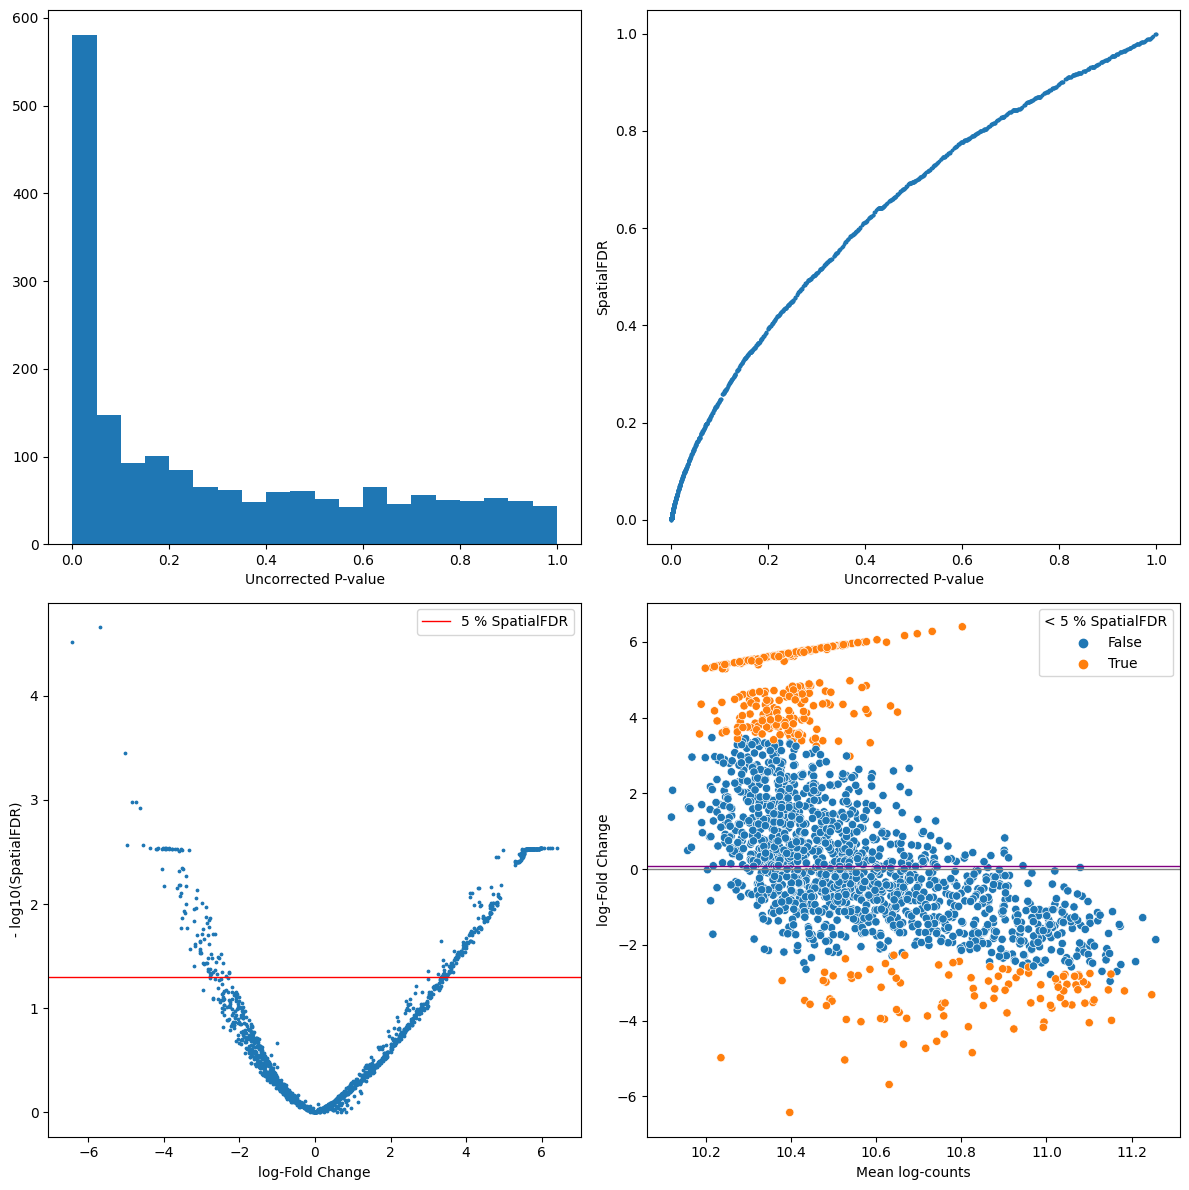

In [38]:
def plot_milo_diagnostics(adata):
    nhood_adata = adata.uns['nhood_adata'].copy()

    with matplotlib.rc_context({'figure.figsize':[12,12]}):

        ## Check P-value histogram
        plt.subplot(2,2,1);
        plt.hist(nhood_adata.obs['PValue'], bins=20);
        plt.xlabel('Uncorrected P-value');

        ## Visualize extent of multiple-testing correction
        plt.subplot(2,2,2);
        plt.scatter(nhood_adata.obs['PValue'], nhood_adata.obs['SpatialFDR'], s=3);
        plt.xlabel('Uncorrected P-value');
        plt.ylabel('SpatialFDR');

        ## Visualize volcano plot
        plt.subplot(2,2,3);
        plt.scatter(nhood_adata.obs['logFC'], -np.log10(nhood_adata.obs['SpatialFDR']), s=3);
        plt.axhline(y=-np.log10(alpha), color='red', linewidth=1, label=f'{int(alpha*100)} % SpatialFDR');
        plt.legend();
        plt.xlabel('log-Fold Change');
        plt.ylabel('- log10(SpatialFDR)');
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df['SpatialFDR'] >= alpha]['logFC'].mean()
        df['Sig'] = df['SpatialFDR'] < alpha

        plt.subplot(2,2,4);
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue='Sig')
        plt.axhline(y=0, color='grey', linewidth=1)
        plt.axhline(y=emp_null, color='purple', linewidth=1);
        plt.legend(title=f'< {int(alpha*100)} % SpatialFDR')
        plt.xlabel('Mean log-counts');
        plt.ylabel('log-Fold Change');
        plt.show()
        
plot_milo_diagnostics(adata)

1. The **P-value histogram** shows the distribution of P-values before multiple testing correction. By definition, we expect the p-values under the null hypothesis (> significance level) to be uniformly distributed, while the peak of p-values close to zero represents the significant results. This gives you an idea of how conservative your test is, and it might help to spot early some pathological cases. For example, if the distribution of P-values looks bimodal, with a second peak close to 1, this might indicate that you have a large number of neighbourhoods with no variance between replicates of one condition (e.g. all replicates from one condition have 0 cells) which might indicate a residual batch effect or that you need to increase the size of neighbourhoods; if the p-value histogram is left-skewed this might indicate a [confounding covariate](https://github.com/MarioniLab/miloR/issues/220#issuecomment-1140812805) has not been accounted for in the model. For other pathological cases and possible interpretations see [this blogpost](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/).
2. For each neighbourhood we plot the uncorrected P-Value VS the p-value controlling for the Spatial FDR. Here we expect the adjusted p-values to be larger (so points above the diagonal). If the FDR correction is especially severe (i.e. many values close to 1) this might indicate a pathological case. You might be testing on too many neighbourhoods (you can reduce `prop` in `milo.make_nhoods`) or there might be too much overlap between neighbourhoods (you might need to decrease _k_ when constructing the KNN graph)
3. The **volcano plot** gives us an idea of how many neighbourhoods show significant DA after multiple testing correction ( - log(SpatialFDR) > 1) and shows how many neighbourhoods are enriched or depleted of cells from the condition of interest.  
4. The **MA plot** shows the dependency between average number of cells per sample and the log-Fold Change of the test. In a balanced scenario, we expect points to be concentrated around logFC = 0, otherwise the shift might indicate a strong imbalance in average number of cells between samples from different conditions. For more tips on how to interpret the MA plot see https://github.com/MarioniLab/miloR/issues/208.

After sanity check, we can visualize the DA results for each neighbourhood by the position of the index cell on the UMAP embedding, to qualitatively assess which cell types may be most affected by the infection.

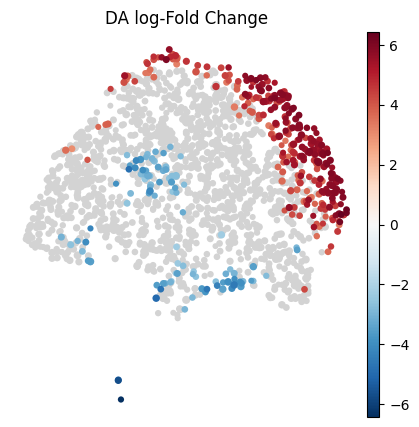

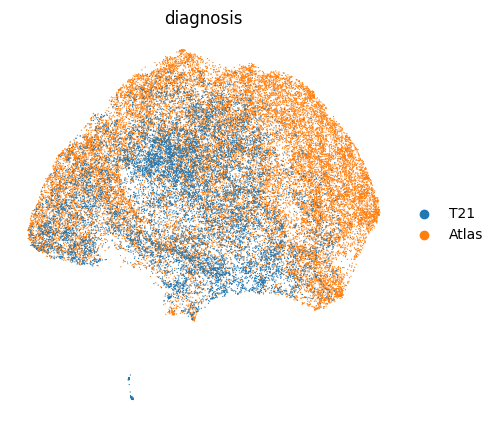

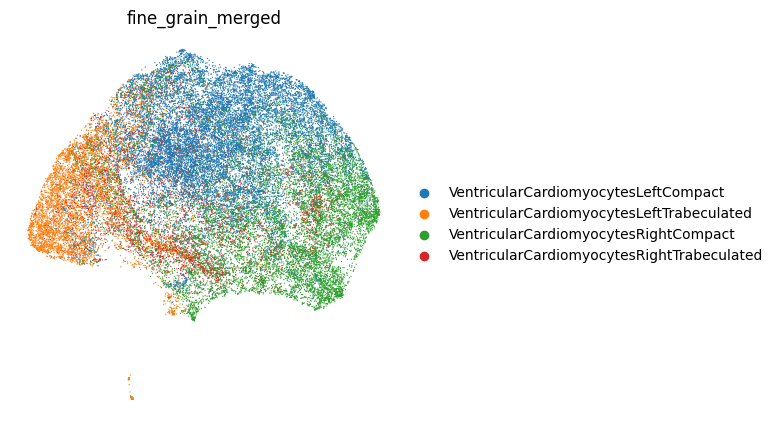

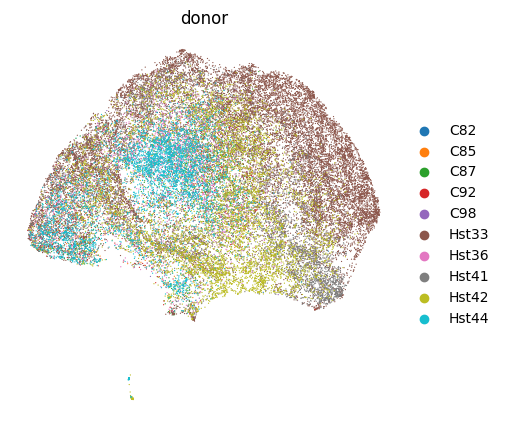

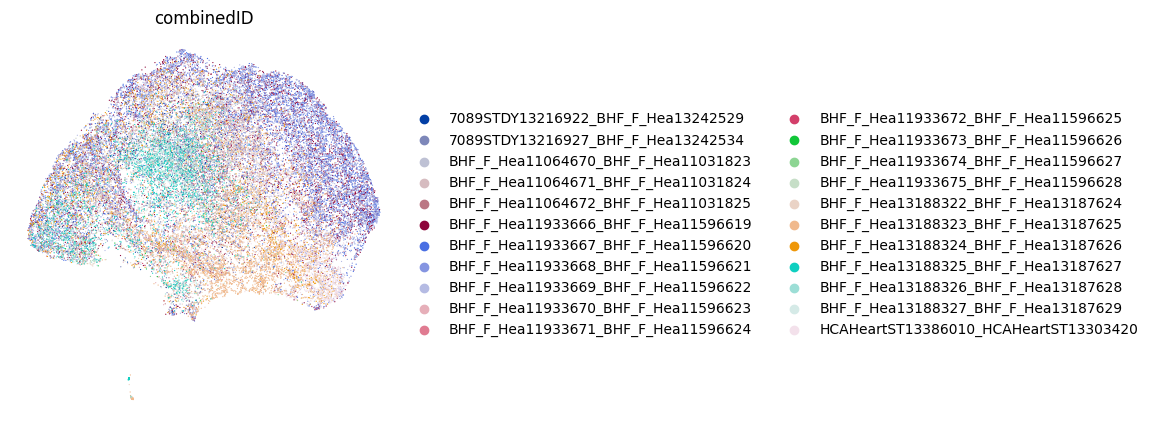

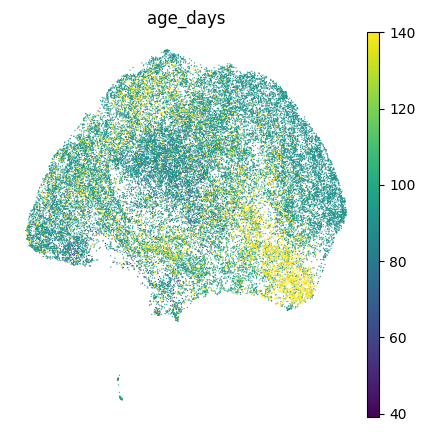

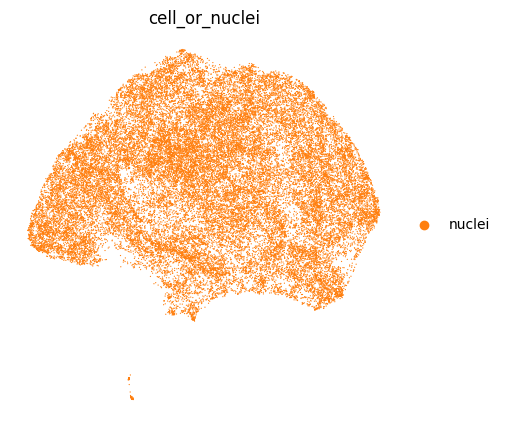

In [39]:
milopy.utils.build_nhood_graph(adata)
with matplotlib.rc_context({'figure.figsize':[5,5]}):
    milopy.plot.plot_nhood_graph(adata, alpha=alpha, min_size=1, plot_edges=False)
    sc.pl.umap(adata, color=['diagnosis'],ncols=1, frameon=False)
    sc.pl.umap(adata, color=['fine_grain_merged'], ncols=1, frameon=False)
    sc.pl.umap(adata, color=['donor'], ncols=1, frameon=False)
    sc.pl.umap(adata, color=['combinedID'], ncols=1, frameon=False)
    sc.pl.umap(adata, color=['age_days'], ncols=1, frameon=False)
    sc.pl.umap(adata, color=['cell_or_nuclei'], ncols=1, frameon=False)

This shows a set of neighbourhoods enriched upon Salmonella infection corresponding to mature enterocytes, and a depletion in a subset of stem cell neighbourhoods. For interpretation of results, it's often useful to annotate neighbourhoods by the cell type cluster that they overlap with

In [40]:
milopy.utils.annotate_nhoods(adata, anno_col='fine_grain_merged')
# Define as mixed if fraction of cells with same label < X
nhood_adata = adata.uns['nhood_adata'].copy()
nhood_adata.obs.loc[nhood_adata.obs['nhood_annotation_frac'] < 0.5, 'nhood_annotation'] = 'Mixed'
adata.uns['nhood_adata'] = nhood_adata.copy()

/lustre/scratch126/cellgen/team205/jc48/jupyter/scArches/fetal/4_MiloDATesting/MiloAtlasT21.svg


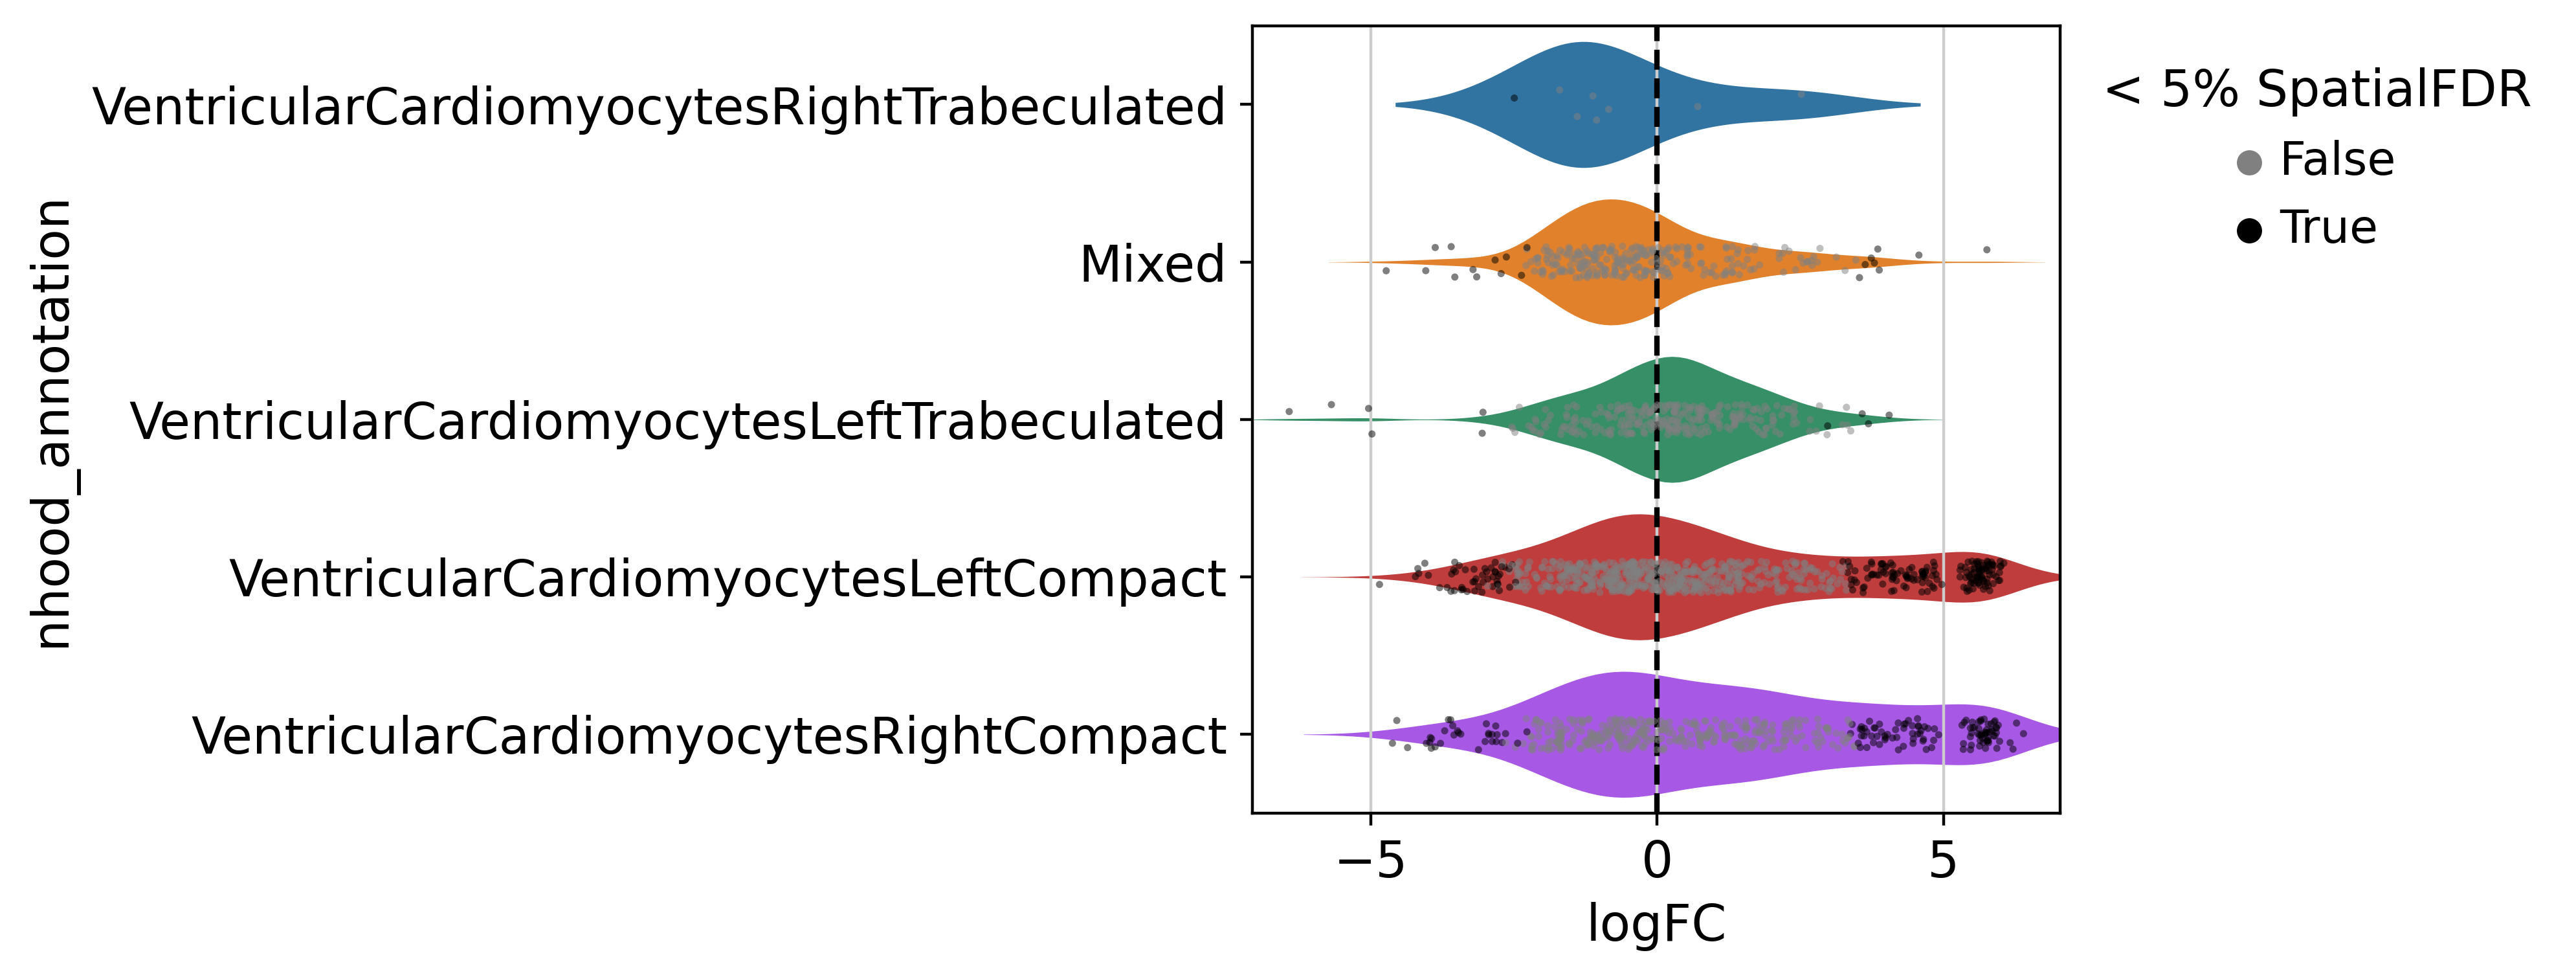

Transferred:   	  337.421 KiB / 337.421 KiB, 100%, 0 B/s, ETA -
Transferred:            0 / 1, 0%
Elapsed time:         1.9s
Transferring:
 *                              MiloAtlasT21.svg:100% /337.421Ki, 0/s, -Transferred:   	  337.421 KiB / 337.421 KiB, 100%, 0 B/s, ETA -
Transferred:            0 / 1, 0%
Elapsed time:         2.4s
Transferring:
 *                              MiloAtlasT21.svg:100% /337.421Ki, 0/s, -Transferred:   	  337.421 KiB / 337.421 KiB, 100%, 336.978 KiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:         2.9s
Transferring:
 *                              MiloAtlasT21.svg:100% /337.421Ki, 337.123Ki/s, 0Transferred:   	  337.421 KiB / 337.421 KiB, 100%, 336.978 KiB/s, ETA 0s
Transferred:            0 / 1, 0%
Elapsed time:         3.4s
Transferring:
 *                              MiloAtlasT21.svg:100% /337.421Ki, 337.123Ki/s, 0Transferred:   	  337.421 KiB / 337.421 KiB, 100%, 336.978 KiB/s, ETA 0s
Transferred:            1 / 1, 100%
Elapsed time:

In [53]:
with matplotlib.rc_context({'figure.figsize':[4,4]}):
    milopy.plot.plot_DA_beeswarm(adata,alpha=alpha)

plot_name="MiloAtlasT21.svg"
cwd=os.getcwd()
path=os.path.join(cwd,plot_name)
print(path)

plt.savefig(path,format='svg',bbox_inches='tight')
plt.show()

! /software/rclone/rclone copy {path} gdrive:Sanger-CSCI_data_share/Manuscript/Figures/Figure6 --drive-shared-with-me --progress

> **What about the compositional effect?** here we identify a strong enrichment upon _Salmonella_ infection in the Enterocytes, but also a depletion in a subset of Stem cells, similarly to what the original authors reported. Although we don't have a ground truth to verify whether the decrease in abundance of stem cells is real, it's important to note that the GLM in Milo doesn't explicitly model the compositional nature of cell abundances in neighbourhoods, so in theory the results could be affected by compositional biases. In practice, performing a test on a large number of neighbourhoods alleviates this issue, since the effect in the opposite direction is distributed across thousands of neighbourhoods rather than tens of cell types. In addition the test used in Milo uses the [trimmed mean of M values normalization method](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2010-11-3-r25) to estimate normalization factors robust to compositional differences across samples. In this particular example, residual compositional effects might be explained by (A) the relatively small number of neighbourhoods (< 1000), (B) the very large effect size in Enterocyte neighbourhoods or (C) the very small number of replicates per condition.   